# Gathering Insight from Kickstarter Data: EDA

_A project by Team Apple (Data Mining & Machine Learning, HEC Lausanne, Fall 2019)_

With the rise of the social web, a new practice known as crowdfunding has appeared, allowing individuals or companies to ask people around the world to invest in their projects. Multiple crowdfunding platforms have emerged since then. Kickstarter is certainly among the most popular ones (especially in the US). In 2019, the company received more than 4 billion USD for 445 thousand different projects in categories such as technology, art, media, etc. The idea behind our machine learning project is to gather insight from Kickstarter’s data in order to determine the key factors to a crowdfunding campaign's success or failure.

We will be using [this dataset](kaggle.com/kemical/kickstarter-projects) from Kaggle. It contains all Kickstarter projects from the launch of the platform until January 2018 (i.e. around 380’000 records). The data was collected directly from the Kickstarter website, probably by means of HTML parsing. For each record, the set provides several useful features such as the name of the project, its main and specific category, the launch date and deadline, the amount of money asked for, its state (failed, cancelled, suspended, succeeded or live), etc.

When there are so many projects to pledge money to, it is difficult, as a project creator, to make your own project stand out from the pack. There is much information that you must provide, and some pieces of information might have more importance than others.

The main goal of this data mining and machine learning project is to address the two following questions:

* Which **features** can help predict with accuracy the success or failure of a Kickstarter project?
* Which **machine learning model** performs the best at doing so?

Before heading into the experimentation of various models, we lay out in this notebook the exploratory data analysis (EDA) performed on the most relevant features of the dataset.

[Link to the GitHub repository](https://github.com/tbacha/DMML2019_Team_Apple)

## Video

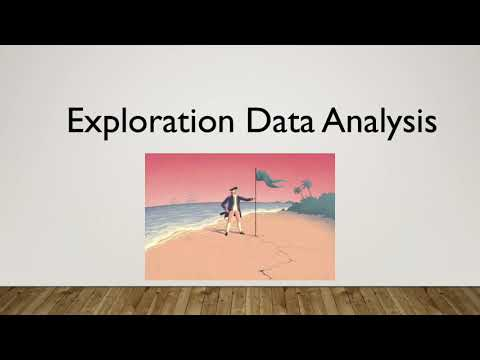

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("P8ZMFhJx0Js", width=600)

## Contributions

* **Project idea**: Frederic Spycher
* **EDA**: Tarik Bacha, Frederic Spycher, Florian Emery
* **Machine learning**: Frederic Spycher, Tarik Bacha, Florian Emery
* **Conclusion**: Florian Emery, Frederic Spycher
* **Video**: Nicolas Mauroux, Florian Emery

## Contents

1. [Imports](#imports)
2. [Loading the data](#loading)
3. [Data cleaning](#cleaning)
4. [Exploratory data analysis (EDA)](#eda)
5. [Machine learning & conclusion](#ml) (on separate notebook)

## 1. Imports<a name="imports"></a>

In [1]:
!pip install squarify

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import squarify
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Loading the data<a name="loading"></a>

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/tbacha/DMML2019_Team_Apple/master/data/ks-projects-201801.csv")
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


## 3. Data cleaning<a name="cleaning"></a>

For several reasons, the dataset in its raw state is only partially usable within the scope of this project. This is why it will undergo several cleaning operations.

In this notebook (EDA), the cleaning process is laid out piece by piece to highlight our reasoning, but the code can also be found in `cleaning.py`, which is imported as a module in the [machine learning notebook](https://github.com/tbacha/DMML2019_Team_Apple/blob/master/code/Kickstarter_notebook_Team_Apple_ML.ipynb) (ML).

### Data types

The first set of operations concerns data types. Two of them, namely `deadline` and `launched`, are time features which were falsely interpreted as floating-point numbers by pandas. To rectify this, we are turning them into datetime objects.

Other than that, all features have the correct type. Categorical features are considered as character strings, which is good enough for our purposes; there is no need to convert them into a `category` data type.

In [6]:
df["deadline"] = pd.to_datetime(df["deadline"])
df["launched"] = pd.to_datetime(df["launched"])
df.dtypes

ID                           int64
name                        object
category                    object
main_category               object
currency                    object
deadline            datetime64[ns]
goal                       float64
launched            datetime64[ns]
pledged                    float64
state                       object
backers                      int64
country                     object
usd pledged                float64
usd_pledged_real           float64
usd_goal_real              float64
dtype: object

### `state` feature

The second set of operations is related to project states. On the Kickstarter platform, they can take one of 6 possible values:

In [7]:
df["state"].unique()

array(['failed', 'canceled', 'successful', 'live', 'undefined',
       'suspended'], dtype=object)

For our project, we are addressing the criteria for success or failure. This means we have to somehow deal with other values of `state`. Since we are unable to determine "undefined" projects actually represent, they are simply removed. Furthermore, the information of "live" and "suspended" projects are subject to change after the capture of this dataset (in January of 2018). Therefore, these observations are also discarded (we are only interested in historical data that can be relied upon).

In [8]:
criteria = df["state"].isin(["failed", "successful", "canceled"])
df = df[criteria]

Since we would like to have only two classes to predict, we also have find a way to work with cancelled projects. There are around 700 projects marked as cancelled, but which actually reached their goal. For the sake of argument, we assume that these were succcessful; all others are considered as failures.

In [9]:
df.loc[(df["state"] == "canceled") & (df["usd_pledged_real"] >= df["usd_goal_real"]), "state"] = "successful"
df.loc[(df["state"] == "canceled") & (df["usd_pledged_real"] < df["usd_goal_real"]), "state"] = "failed"

Finally, to satisfy the prerequisites of some machine learning models, the "successful" and "failed" values are replaced by 1 and 0 respectively. 

In [10]:
df.loc[(df["state"] == "successful"), "state"] = 1
df.loc[(df["state"] == "failed"), "state"] = 0
df["state"].unique()

array([0, 1], dtype=int64)

### Other features

When it comes to money features, the original dataset already came with normalized amounts in US dollars for `goal` and `pledged`. We are not taking into account currency exchange rate fluctuations over time, as this would needlessly raise the complexity of our task. Therefore, we have no need for those features anymore.

Moreover, the `usd pledged` feature seems to serve no apparent purpose, and some of its values seem faulty. If one looks at the second row of the dataframe (see [above](#loading)), the pledged amount should be 2421.0 USD, but this feature contains a value of 100.0. Since `usd_pledged_real` has all the information we need, we are removing `usd pledged`.

In [11]:
df = df.drop(["goal", "pledged", "usd pledged"], axis=1)

### Additional features

For analysis and machine learning purposes, we are adding two new features:

* **Success rate**: this represents the percentage of the goal that was achieved (also referred to as the "degree of success");
* **Elapsed time**: the time that passed between the launch date and the deadline.

In [12]:
df["pct_reached"] = round(df["usd_pledged_real"] / df["usd_goal_real"], 2)
df["elapsed_time"] = df["deadline"] - df["launched"]
df[["pct_reached", "elapsed_time"]].head()

,pct_reached,elapsed_time
0,0.00,58 days 11:47:32
1,0.08,59 days 19:16:03
2,0.00,44 days 23:39:10
3,0.00,29 days 20:35:49
4,0.07,55 days 15:24:57


### Noisy values

In the search for noisy values, we find that there are 201 projects which somehow managed to raise money without the support of any backers. This also revealed a noisy value for `country` (N,0"). Since those records seem to be corrupted, we are removing them.

In [13]:
criteria = (((df["backers"]==0) & (df["usd_pledged_real"] > 0) | (df["country"] == 'N,0"')))
df = df[~criteria]

We also find that there are 3 projects for which no name was entered. Since the values of the other features make sense, and since the role played by a project's name in its success is only marginal, we decide to keep those records.

In [14]:
df[pd.isnull(df).any(axis=1)]

,ID,name,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real,pct_reached,elapsed_time
166851,1848699072,NaN,Narrative Film,Film & Video,USD,2012-02-29,2012-01-01 12:35:31,0,1,US,100.00,200000.00,0.00,58 days 11:24:29
307234,634871725,NaN,Video Games,Games,GBP,2013-01-06,2012-12-19 23:57:48,0,12,GB,316.05,3224.97,0.10,17 days 00:02:12
338931,796533179,NaN,Painting,Art,USD,2011-12-05,2011-11-06 23:55:55,0,5,US,220.00,35000.00,0.01,28 days 00:04:05


### Final cleaning

The index is updated in order to avoid further complications during the data analysis and machine learning processes (especially when concatenating dataframes).

In [15]:
df.reset_index(inplace=True, drop=True)
df.tail(1)

,ID,name,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real,pct_reached,elapsed_time
370218,999988282,Nou Renmen Ayiti! We Love Haiti!,Performance Art,Art,USD,2011-08-16,2011-07-19 09:07:47,0,17,US,524.0,2000.0,0.26,27 days 14:52:13


In [16]:
df.shape

(370219, 14)

## 4. Exploratory data analysis (EDA)<a name="eda"></a>

Our cleaned version of the dataset contains 370'219 records and 14 features.

The features we suspect to have the most impact on the success (`state` = 1) of projects are:
* `main_category`
* `category`
* `usd_goal_real`
* `country`
* `launched`, `deadline` (and the derived `elapsed_time`)

Therefore we will focus on these for the EDA. Also, since the number of backers can also be an indicator of success, the final part of the EDA is dedicated to it.

### States: base rate and degree of success

The following graph gives us the base rates of `state`. The majority class is "failed" (0) with 63.7%.

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Text(0, 0.5, '')

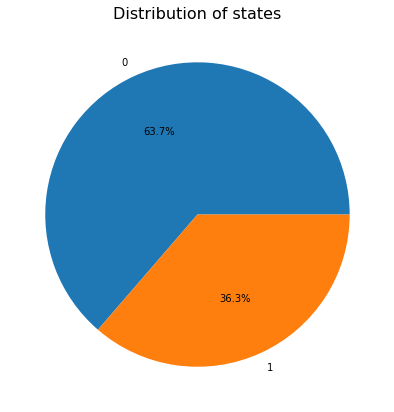

In [15]:
df_state = df[(df["state"] != "undefined")].groupby(["state"])["ID"].nunique()
ax = df_state.plot(kind="pie", figsize=(7,7), autopct="%1.1f%%")
ax.set_title("Distribution of states", size=16)
ax.set_ylabel("")

Interestingly, we see that, on average, failed and canceled projects tend to ask for a much higher amount of money than successful ones.

Text(0, 0.5, 'Goal (USD)')

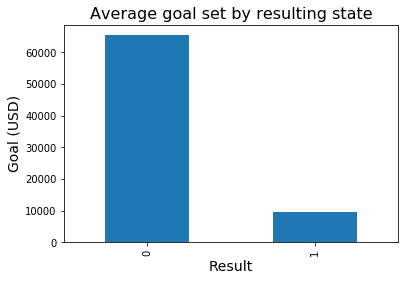

In [16]:
df_goal_state = df.groupby(["state"])["usd_goal_real"].mean()
ax = df_goal_state.plot(kind="bar")
ax.set_title("Average goal set by resulting state", size=16)
ax.set_xlabel("Result", size=14)
ax.set_ylabel("Goal (USD)", size=14)

We now turn to the **degree of success** (as captured by the computed `pct_reached` feature).

The bulk of projects has reached 100% of its goal or less. The more successful projects can generate up to 2.5 times the amount they asked for.

There is an non-negligible number of outliers above the upper bound (about 18,000), the best ones having a ridiculously high percentage of success (max = 104,277.89 %). This is typically when the project creator asked only for a low amount of money (e.g. 1 or 10 USD) then met with tremendous success.

In the following graphs, we represent the distribution of `pct_reached`.

As we can see on the figure below, the values are very stretched. On the right figure, we zoom in on a range excluding outliers.
It starts to look somewhat like a **log-normal** distribution. 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


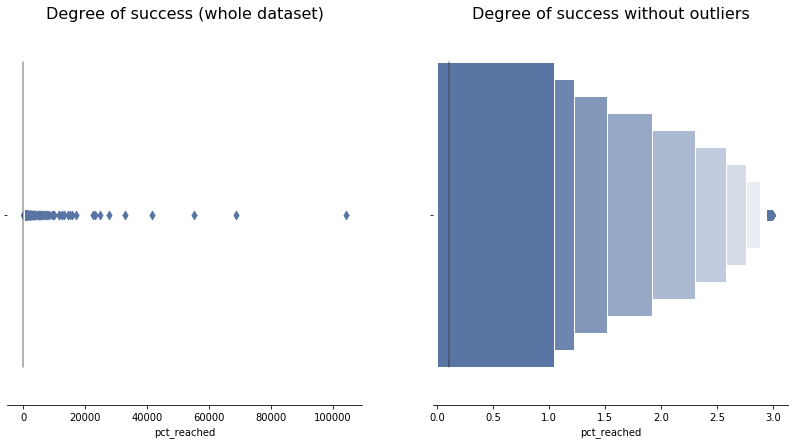

In [17]:
q1,q3 = np.percentile(df["pct_reached"],[25,75])
q1_suc,q3_suc = np.percentile(df[df['state']==1]["pct_reached"],[25,75])

upper_bound = round((q3 +(1.5 * (q3 - q1))),0)
upper_bound_suc = round((q3_suc +(1.5 * (q3_suc - q1_suc))),0)

f, axes = plt.subplots(1, 2, figsize=(14, 7), sharex=False)
sns.set(style="whitegrid")
sns.despine(left=True)
sns.boxenplot(x="pct_reached",color="b", scale="linear", data=df,ax=axes[0]).set_title("Degree of success (whole dataset)", size=16)
sns.boxenplot(x="pct_reached",color="b", scale="linear", data=df[df["pct_reached"]<upper_bound],ax=axes[1]).set_title("Degree of success without outliers", size=16)
plt.show()

In the figure below, we are plotting `pct_reached` to check if it corresponds to a log-normal distribution.

On the left side, it still looks like a log-normal distribution, but with noise. The zoomed part of the right side (95% of the data) shows that it is not noise; the shape is more like that of a signal activation or two log-normal. At the second row of figures, we split the dataframe by `state` (failed on the left, successful on the right).

In both cases, the `pct_reached` indeed follows a **log-normal** distribution. This information allows us to compute the cumulative probability of these functions and thus to predict with reasonable accuracy the probability of reaching a certain amount of money.

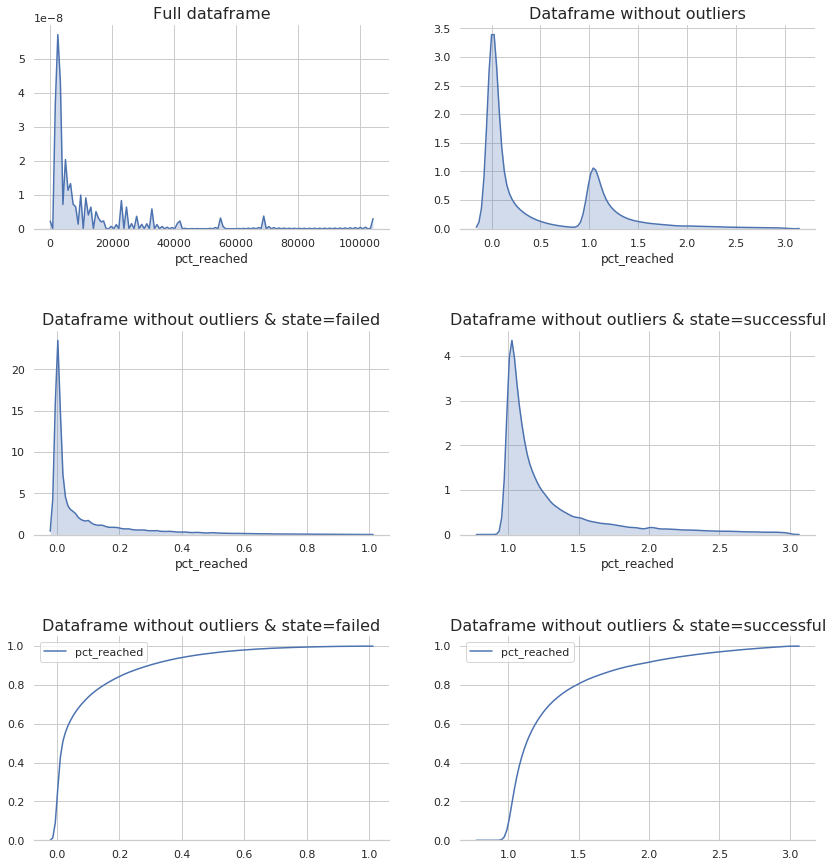

In [18]:
f, axes = plt.subplots(3, 2, figsize=(14, 15), sharex=False)
sns.despine(left=True)
f.subplots_adjust(hspace=.5)
axes[0,0].set_title('Full dataframe', size=16)
axes[0,1].set_title('Dataframe without outliers', size=16)
axes[1,0].set_title('Dataframe without outliers & state=failed', size=16)
axes[1,1].set_title('Dataframe without outliers & state=successful', size=16)
axes[2,0].set_title('Dataframe without outliers & state=failed', size=16)
axes[2,1].set_title('Dataframe without outliers & state=successful', size=16)
sns.distplot(df["pct_reached"], hist=False, color="b", kde_kws={"shade": True},ax=axes[0,0])#.set_xlabel('') #first row left
sns.distplot(df[df["pct_reached"]<upper_bound]["pct_reached"], hist=False, color="b", kde_kws={"shade": True},ax=axes[0,1])#.set_xlabel('') #first row right
sns.distplot(df[(df["pct_reached"]<1) & ((df["state"]==0))]["pct_reached"], hist=False, color="b", kde_kws={"shade": True},ax=axes[1,0])
sns.distplot(df[(df["pct_reached"]<upper_bound_suc) & ((df["state"]==1))]["pct_reached"], hist=False, color="b", kde_kws={"shade": True},ax=axes[1,1])
sns.kdeplot(df[(df["pct_reached"]<1) & ((df["state"]==0))]["pct_reached"], cumulative=True,ax=axes[2,0])
sns.kdeplot(df[(df["pct_reached"]<upper_bound_suc) & ((df["state"]==1))]["pct_reached"], cumulative=True,ax=axes[2,1])

plt.show()

In [0]:
shape, location, scale = scipy.stats.lognorm.fit(df[(df["pct_reached"]<2.7) & ((df["state"]==0))]["pct_reached"])
shape1, location1, scale1 = scipy.stats.lognorm.fit(df[(df["pct_reached"]<2.7) & ((df["state"]==1))]["pct_reached"])
mu, sigma = np.log(scale), shape
mu1, sigma1 = np.log(scale1), shape1
#print("mu 'failed'=   ",round(mu,2),'\n' "sigma 'failed'= ",round(sigma,2),'\n' "mu 'successful'=   ",round(mu1,2),'\n'"sigma 'successful'= ",round(sigma1,2))

#### Base-rate and degree of success: conclusion

From this analysis, we draw our first conclusion: most of the time, if you are successful, **the amount of money pledged to your project will be close to the amount you ask for.**

The `pct_reached` follows two **log-normal** distributions with the following parameters:

* Failed:
    * $\mu = -3.75$ and $\sigma = 15.96$
* Successful:
    * $\mu = -1.12$ and $\sigma = 0.67$

### Main categories<a name="mcat"></a>

In this section, we wanted to find out the repartition of the `main_category`. It turns out that close to a **third** of all projects are either related to the movie or the music industry.

The figure below presents all the main categories with their respective number of successful and failed projects.

<Figure size 1152x864 with 0 Axes>

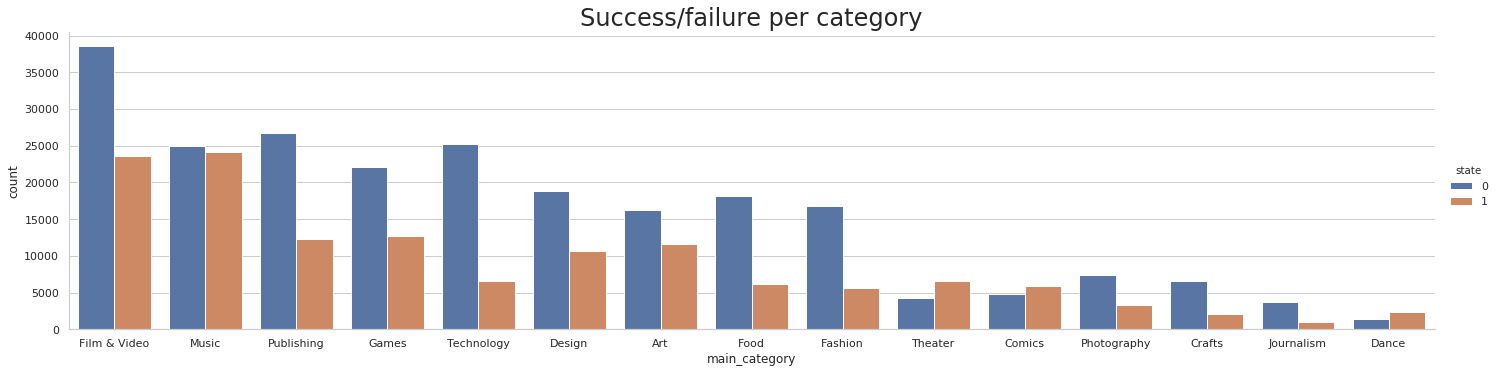

In [20]:
df_ordered_cat = df.sort_values(by=["main_category"],ascending=True)
listeOrder = df.groupby(["main_category"])["ID"].nunique().sort_values(ascending=False).index.tolist()
fig = plt.gcf()
fig.set_size_inches(16, 12)
sns.catplot(kind="count", data=df_ordered_cat, x="main_category", hue="state", height=5, aspect=4, order=listeOrder )
plt.title("Success/failure per category", size=24)
plt.show()

In [21]:
df_main_cat = df.groupby(["main_category"])["ID"].nunique().sort_values(ascending=True)
print("Percentage of projects in the film and music industries:", round(((df_main_cat.iloc[-1] + df_main_cat.iloc[-2]) / df.shape[0] * 100),2),"%")

Percentage of projects in the film and music industries: 30.08 %


#### Main categories: conclusion

By analyzing the distribution of `main_category`, we find that the **most valuable** ones are:

* **Theater**
* **Dance**
* **Comics**

Indeed, they are the only main categories with _more_ successful projects than failed ones.

### Categories

We are now looking more closely at the `category` feature, which is a refinement of the `main_category`. Because there are a lot of categories (159), we chose to look only at the subcategories of the _most valuable main categories_ (MVMC) mentioned above, and at those of the _3 largest main categories_ (LMC).

<Figure size 1152x864 with 0 Axes>

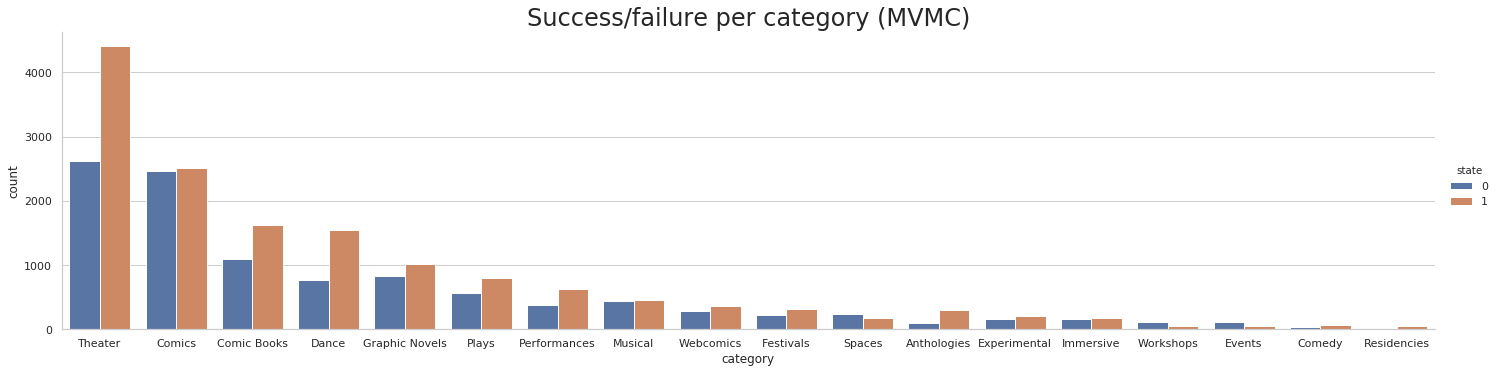

In [22]:
df1 = df[(df["main_category"]=='Theater') | (df["main_category"]=='Dance') | (df["main_category"]=='Comics')]
df_ordered_cat = df1.sort_values(by=["category"],ascending=True)
listeOrder = df1.groupby(["category"])["ID"].nunique().sort_values(ascending=False).index.tolist()
fig = plt.gcf()
fig.set_size_inches(16, 12)
sns.catplot(kind="count", data=df_ordered_cat, x="category", hue="state", height=5, aspect=4, order=listeOrder )
plt.title("Success/failure per category (MVMC)",fontsize=24)
plt.show()

<Figure size 4320x864 with 0 Axes>

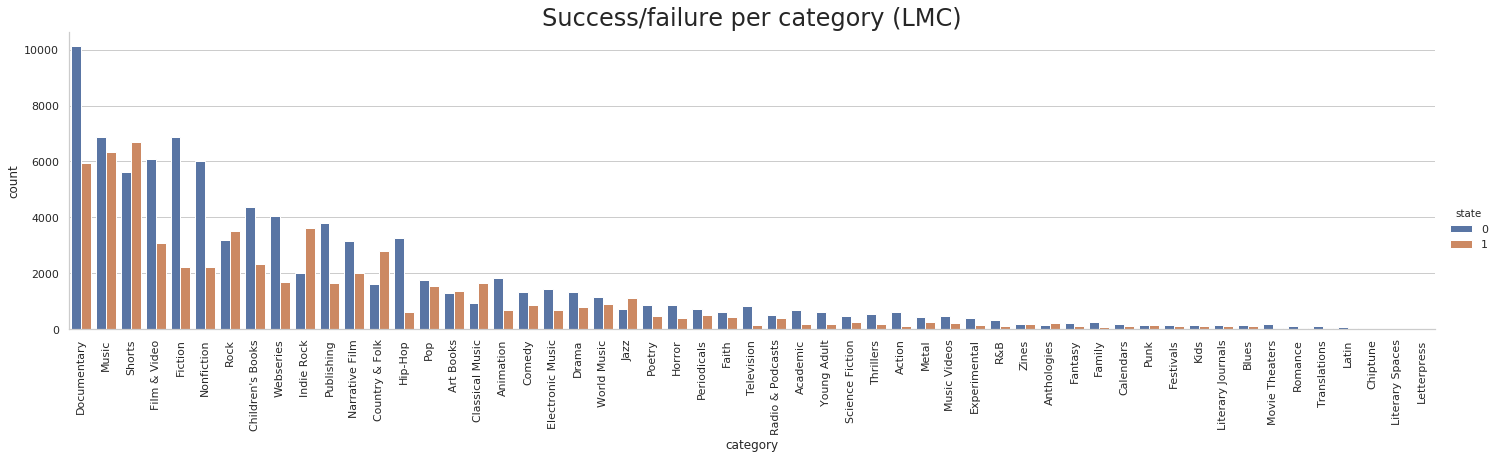

In [23]:
df2 = df[(df["main_category"]=='Film & Video') | (df["main_category"]=='Music') | (df["main_category"]=='Publishing')]
df_ordered_cat = df2.sort_values(by=["category"],ascending=True)
listeOrder = df2.groupby(["category"])["ID"].nunique().sort_values(ascending=False).index.tolist()
fig = plt.gcf()
fig.set_size_inches(60, 12)
P=sns.catplot(kind="count", data=df_ordered_cat, x="category", hue="state", height=5, aspect=4, order=listeOrder )
P.set_xticklabels(rotation=90)
plt.title("Success/failure per category (LMC)",fontsize=24)
plt.show()

#### Categories: conclusion
Suprisingly, the **most valuable** `category` of the MVMC is **Anthologies**. This could be explained by the small number of projects as well as the fact it is a subject who speaks mainly to an audience of experts.

As expected, the music is the `main_category` with the best sub-categories. Once again, the **most valuable** categories are not "mainstream" categories and rather target experts.

This leads us to think that the "best way" to ensure the success of a project is to avoid mainstream subjects.

### Countries

Unsurprisingly, Kickstarter being an English-speaking platform first and foremost, the top 3 most represented countries are the **USA** (by a large margin), the **UK** and **Canada**. Then come German and French-speaking countries.

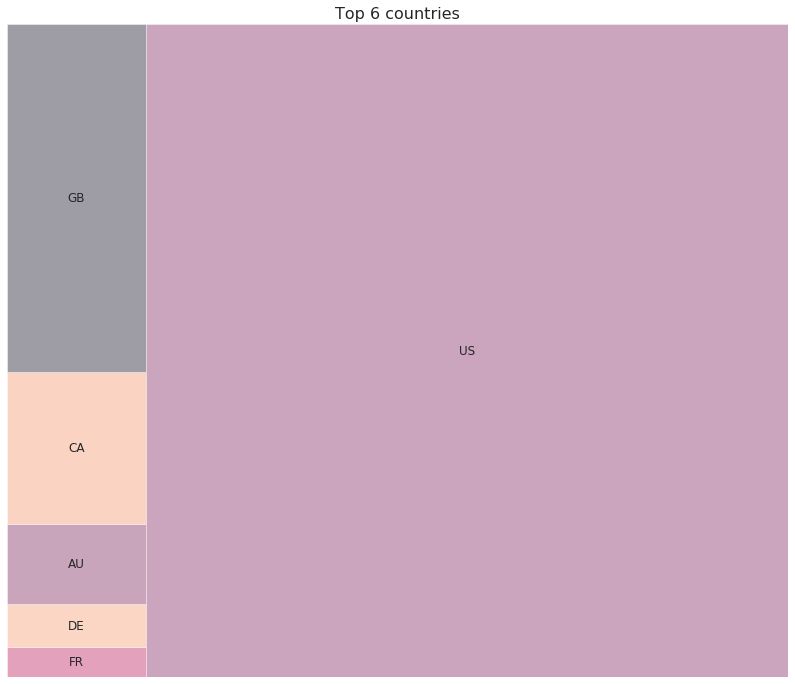

In [24]:
fig = plt.gcf()
fig.set_size_inches(14, 12)
df_country = df.groupby(["country"])["ID"].count().sort_values()
forMap = df_country.tail(6)
Numb = forMap.values.tolist()
Title = forMap.index.tolist()
squarify.plot(sizes=Numb, label=Title, alpha= 0.4)
plt.title("Top 6 countries",fontsize=16)
plt.axis('off')
plt.show()

In the figure below, we can see that the countries with the best success rate are:

* **USA**
* **UK**
* **France**



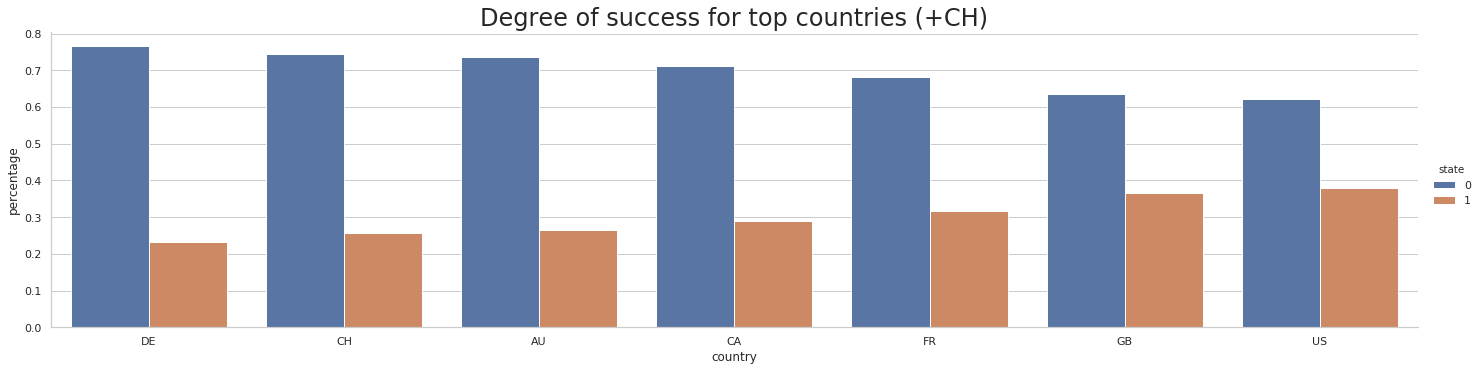

In [25]:
df_selected_countries = df[(df["country"].isin(["US", "GB", "CA", "AU", "DE", "FR", "CH"]))]
df_new = df_selected_countries.groupby(['country'])['state'].value_counts(normalize=True).rename('percentage').reset_index().sort_values('percentage', ascending=True)
sns.catplot(kind="bar", data=df_new, x="country", y="percentage", hue="state", height=5, aspect=4)
plt.title("Degree of success for top countries (+CH)", size=24)
plt.show()

Because North America represents such a large portion of the data, we were curious to look at the situation in **non-NA countries**. The figure below shows us the percentage of the goal reached (on average) for each of them, and thus how **profitable** they are. Clearly, Kickstarter does not seem to work well for Swiss projects compared to one of its neighbors, France.

Text(0, 0.5, 'Success rate')

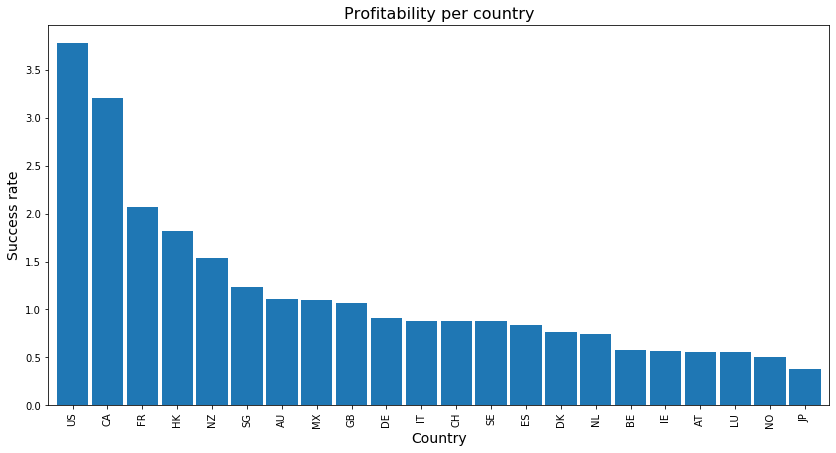

In [20]:
df_without_na = df.groupby(["country"])["pct_reached"].mean().sort_values(ascending= False)
ax = df_without_na.plot(kind="bar", width=0.9, figsize=(14, 7))
ax.set_title("Profitability per country", size=16)
ax.set_xlabel("Country", size=14)
ax.set_ylabel("Success rate", size=14)

Finally, we wanted to answer two questions about our own country, **Switzerland**:

1. Which main categories have the highest number of successful projects in Switzerland?
2. How much do they ask for on average?

Text(0, 0.5, 'Goal (USD)')

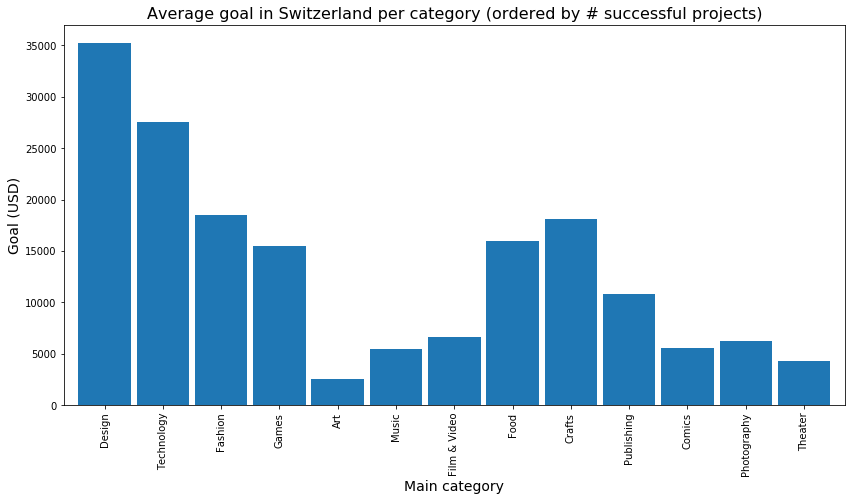

In [21]:
df_switzerland = df[(df["country"] == "CH") & (df["state"] == 1)].groupby(["main_category"])[["ID", "usd_goal_real"]].agg({"ID":"count", "usd_goal_real":"mean"}).sort_values(by="ID", ascending=False)
ax = df_switzerland["usd_goal_real"].plot(kind="bar", width=0.9, figsize=(14, 7))
ax.set_title("Average goal in Switzerland per category (ordered by # successful projects)", size=16)
ax.set_xlabel("Main category", size=14)
ax.set_ylabel("Goal (USD)", size=14)

#### Countries: conclusion

The most represented countries are the English-speaking ones. But, surprisingly, France is more interesting in terms of profitability than the UK (although it is still behind NA countries by quite a margin).

Another interesting thing to point out is that the main categories where the most projects become successful in Switzerland differ quite a lot from the "standard" ones (see [Main categories](#mcat)).

### Other features





As we can see below, the numbers of backers is pretty random and the spread is really big. Considering the mean (263), the median (71) and mode (19), we understand that outliers also reach rather big proportions.

In [28]:
df.groupby(['state'])['backers'].agg(['mean','min','max','median',('mode',lambda x: x.mode()[0])])

,mean,min,max,median,mode
state,,,,,
0,17.514853,0,9326,3,0
1,263.704277,1,219382,71,19


This becomes more evident in the set of figures below, where we plotted the distribution of backers. The first row represents data for both states, whereas the second one distinguishes between them.

Just like the degree of success (`pct_reached`) that we have seen previously, the spread is massive, and so is the number of outliers. That is why we represented some of the plots to hide the last few quantiles. Again, the density looks like a **log-normal** distribution.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

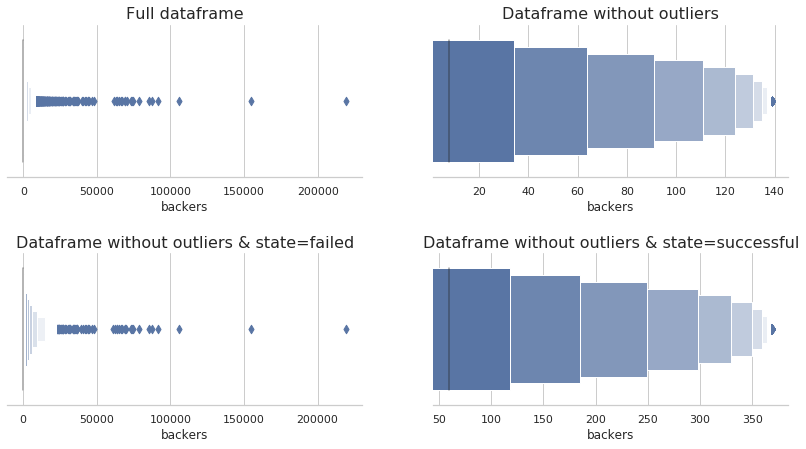

In [29]:
f, axes = plt.subplots(2, 2, figsize=(14, 7), sharex=False)
q1,q3 = np.percentile(df["backers"],[25,75])
q1_suc,q3_suc = np.percentile(df[df['state']==1]["backers"],[25,75])
upper_bound = round((q3 +(1.5 * (q3 - q1))),0)
upper_bound_suc = round((q3_suc +(1.5 * (q3_suc - q1_suc))),0)
f.subplots_adjust(hspace=.5)
axes[0,0].set_title('Full dataframe', size=16)
axes[0,1].set_title('Dataframe without outliers', size=16)
axes[1,0].set_title('Dataframe without outliers & state=failed', size=16)
axes[1,1].set_title('Dataframe without outliers & state=successful', size=16)
sns.despine(left=True)
sns.boxenplot(x="backers",color="b", scale="linear", data=df, ax=axes[0,0])
sns.boxenplot(x="backers",color="b", scale="linear", data=df[df["backers"]<upper_bound], ax=axes[0,1])
sns.boxenplot(x="backers",color="b", scale="linear", data=df[df['state']==1], ax=axes[1,0])
sns.boxenplot(x="backers",color="b", scale="linear", data=df[(df["backers"]<upper_bound_suc) & (df['state']==1) ], ax=axes[1,1])
plt.show()

This is indeed confirmed by the plots below. Whether for failed or successful projects, the distributions are **log-normal**. As in the `pct_sucess` we are able to compute the cumulative distribution of each function.

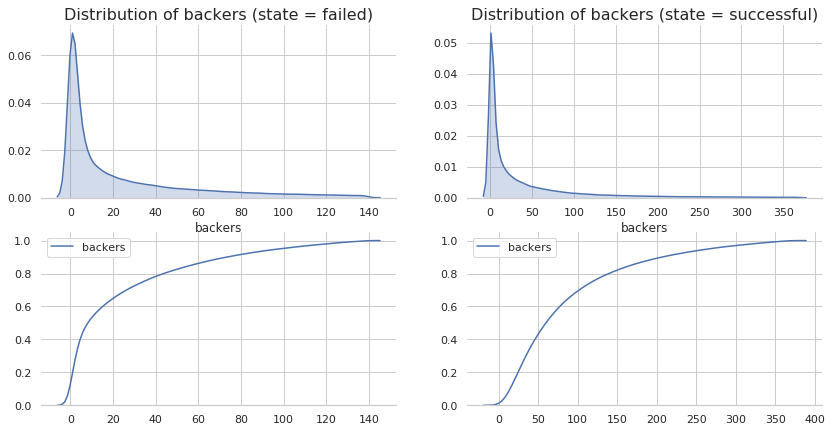

In [30]:
f, axes = plt.subplots(2, 2, figsize=(14, 7), sharex=False)
sns.despine(left=True)
axes[0,0].set_title('Distribution of backers (state = failed)', size=16)
axes[0,1].set_title('Distribution of backers (state = successful)', size=16)
sns.distplot(df[df["backers"]<upper_bound]["backers"], hist=False, color="b", kde_kws={"shade": True},ax=axes[0,0])
sns.distplot(df[df["backers"]<upper_bound_suc]["backers"], hist=False, color="b", kde_kws={"shade": True},ax=axes[0,1])
sns.kdeplot(df[df["backers"]<upper_bound]["backers"], cumulative=True,ax=axes[1,0])
sns.kdeplot(df[(df["backers"]<upper_bound_suc) & (df['state']==1) ]["backers"], cumulative=True,ax=axes[1,1])
plt.show()

In [31]:
shape, location, scale = scipy.stats.lognorm.fit(df[df["backers"]<upper_bound]["backers"])
shape1, location1, scale1 = scipy.stats.lognorm.fit(df[(df["backers"]<upper_bound_suc) & (df['state']==1) ]["backers"])
mu_fail, sigma_fail = np.log(scale), shape
mu_succ, sigma_succ = np.log(scale1), shape1
print("mu 'failed'=   ",round(mu_fail,2),'\n' "sigma 'failed'= ",round(sigma_fail,2),'\n' "mu 'successful'=   ",round(mu_succ,2),'\n'"sigma 'successful'= ",round(sigma_succ,2))

mu 'failed'=    2.68 
sigma 'failed'=  9.94 
mu 'successful'=    0.81 
sigma 'successful'=  4.11


In the table below, we show the main statistics of `backers` per `main_category`. With no surprise, the means and the maxima are related.

The interested things is that, again, we come across our MVMC; all of them are in the top 5 median values.

In [32]:
df.groupby(['main_category'])['backers'].agg(['mean','min','max','median', ('mode',lambda x: x.mode()[0])]).sort_values(["median"], ascending=False).head(7)

,mean,min,max,median,mode
main_category,,,,,
Comics,135.629198,0,14952,40,0
Games,325.597753,0,219382,30,0
Design,241.609948,0,154926,29,0
Dance,43.097430,0,4133,27,0
Theater,47.222488,0,3722,25,0
Music,55.000224,0,24883,19,0
Film & Video,67.325804,0,91585,12,0


The objective of the following grid is to find correlations between numerical/date variables. To better visualize the data concerning `usd_goal_real`, we resized the figure by hiding values above the maximum goal value found within successful projects.

Without any suprise, the relation between the backers and the pledge is the closest. Also, when looking at the goal, we can see a clear threshold between failure and success.
To have a better view of the value, we split the dataset in two part by the state.

In [23]:
limit = round((df[df['state']==1]['usd_goal_real'].max()),0)
limit

2015609.0

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: The handle <matplotlib.patches.Patch object at 0x000002683B660198> has a label of '_nolegend_' which cannot be automatically added to the legend.
  **kwargs)


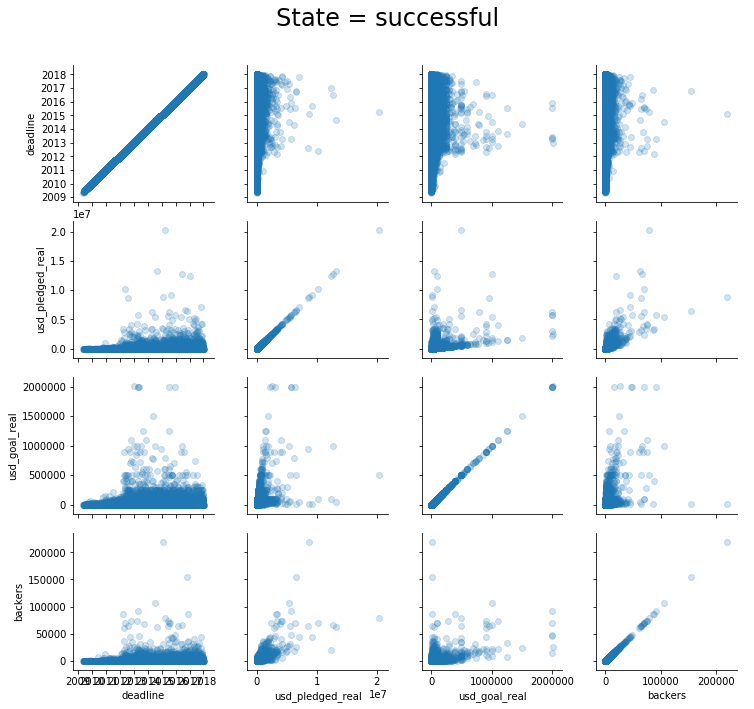

In [26]:
g = sns.PairGrid(df[(df["usd_goal_real"]<limit) & (df["state"]==1)], vars=['deadline', 'usd_pledged_real', 'usd_goal_real', 'backers'],
                  palette='BrBG')
g.map(plt.scatter, alpha=0.2)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('State = successful', size=24)
g.add_legend();

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: The handle <matplotlib.patches.Patch object at 0x0000026837C0F828> has a label of '_nolegend_' which cannot be automatically added to the legend.
  **kwargs)


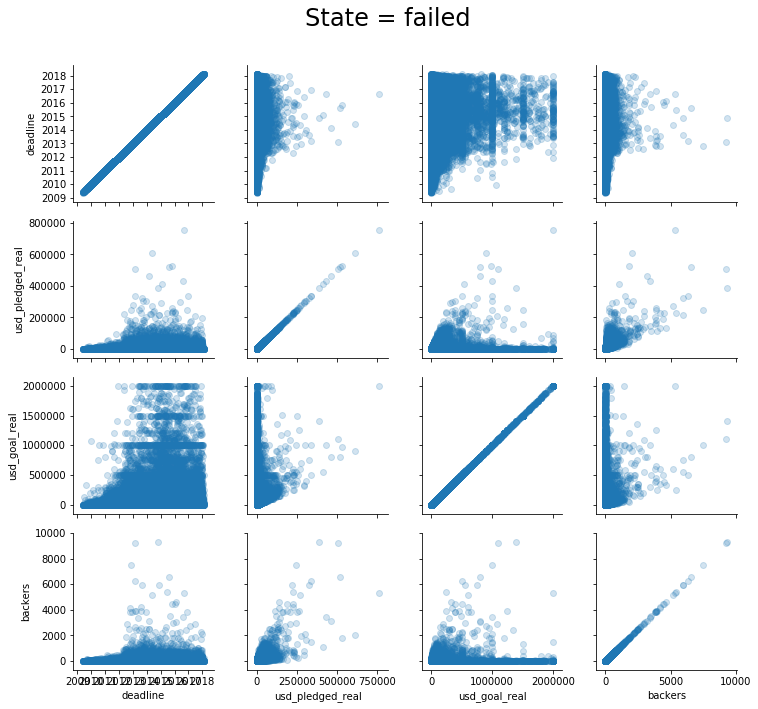

In [25]:
g = sns.PairGrid(df[(df["usd_goal_real"]<limit) & (df["state"]==0)], vars=['deadline', 'usd_pledged_real', 'usd_goal_real', 'backers'],
                 palette='pale red')
g.map(plt.scatter, alpha=0.2)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('State = failed', size=24)
g.add_legend();

#### Other features: conclusion

Since backers follow a log-normal distribution, we could now actually predict the number of backers for a given project using the $\mu$ and $\sigma$ parameters listed previously.

Unfortunately, we were not able to find any clear correlation between numerical/date features.

## 5. Machine learning & conclusion<a name="ml"></a>

This is the end of the notebook dedicated to EDA. The [machine learning](https://github.com/tbacha/DMML2019_Team_Apple/blob/master/code/Kickstarter_notebook_Team_Apple_ML.ipynb) section is waiting for you...